In this notebook, I demonstrate how to use the multiclass focal loss that should help you score better with such imbalanced classes. The focal loss function is from https://github.com/artemmavrin/focal-loss/blob/master/docs/source/index.rst

The focal loss is a loss that has been devised for object detection problems where the background is more prominent than the objects to be detected. 

![](https://github.com/Atomwh/FocalLoss_Keras/raw/master/images/fig1-focal%20loss%20results.png)

As you increase the gamma value, you put more emphasis on hard to classify examples. There is clearly a trade-off for this (high gamma values can be detrimental), but overall if you set the right value it should perform much better than using other tricks for imbalanced data.

This notebook owes quite a lot of ideas from "TPSDEC21-01-Keras Quickstart" (https://www.kaggle.com/ambrosm/tpsdec21-01-keras-quickstart) by @ambrosm please consider upvoting also his work.

It also implements the feature engineering suggested by @aguschin (see my post https://www.kaggle.com/c/tabular-playground-series-dec-2021/discussion/291839 for all the references).

In [1]:
!pip install git+https://github.com/artemmavrin/focal-loss.git

  Cloning https://github.com/artemmavrin/focal-loss.git to /tmp/pip-req-build-1vadnnlh
  Running command git clone -q https://github.com/artemmavrin/focal-loss.git /tmp/pip-req-build-1vadnnlh
  Resolved https://github.com/artemmavrin/focal-loss.git to commit 7a1810a968051b6acfedf2052123eb76ba3128c4
  Created wheel for focal-loss: filename=focal_loss-0.0.8-py3-none-any.whl size=19050 sha256=eac7b6341b4167fe6ee12058305e5aafed62bb82ae884ace396d13b8c4f277e8
  Stored in directory: /tmp/pip-ephem-wheel-cache-8uuqbjsa/wheels/a2/9b/0f/a4d351aeb42d31330a290569400d5ff7bb54938658a508e9cd
Successfully built focal-loss
  Attempting uninstall: typing-extensions
    Found existing installation: typing-extensions 3.10.0.2
    Uninstalling typing-extensions-3.10.0.2:
      Successfully uninstalled typing-extensions-3.10.0.2
  Attempting uninstall: six
    Found existing installation: six 1.16.0
    Uninstalling six-1.16.0:
      Successfully uninstalled six-1.16.0
ERROR: pip's dependency resolver does 

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import plot_model
from warnings import filterwarnings
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.preprocessing import QuantileTransformer, LabelEncoder
from sklearn.model_selection import StratifiedKFold, KFold

filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'

In [3]:
from focal_loss import SparseCategoricalFocalLoss
from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import Dense, BatchNormalization, Flatten, Input, Concatenate, Dropout
from tensorflow.keras.utils import to_categorical
import tensorflow_addons as tfa

In [4]:
def plot_keras_history(history, measures):
    """
    history: Keras training history
    measures = list of names of measures
    """
    rows = len(measures) // 2 + len(measures) % 2
    fig, panels = plt.subplots(rows, 2, figsize=(15, 5))
    plt.subplots_adjust(top = 0.99, bottom=0.01, hspace=0.4, wspace=0.2)
    try:
        panels = [item for sublist in panels for item in sublist]
    except:
        pass
    for k, measure in enumerate(measures):
        panel = panels[k]
        panel.set_title(measure + ' history')
        panel.plot(history.epoch, history.history[measure], label="Train "+measure)
        panel.plot(history.epoch, history.history["val_"+measure], label="Validation "+measure)
        panel.set(xlabel='epochs', ylabel=measure)
        panel.legend()
        
    plt.show(fig)

In [5]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [6]:
train = pd.read_csv("../input/tabular-playground-series-dec-2021/train.csv")
test = pd.read_csv("../input/tabular-playground-series-dec-2021/test.csv")
submission = pd.read_csv("../input/tabular-playground-series-dec-2021/sample_submission.csv")

In [7]:
# source: https://www.kaggle.com/remekkinas/tps-12-nn-tpu-pseudolabeling-0-95661
pseudolabels = pd.read_csv("../input/tps12-pseudolabels/tps12-pseudolabels_v2.csv")

In [8]:
print("The target class distribution:")
print((train.groupby('Cover_Type').Id.nunique() / len(train)).apply(lambda p: f"{p:.3%}"))

The target class distribution:
Cover_Type
1    36.703%
2    56.552%
3     4.893%
4     0.009%
5     0.000%
6     0.286%
7     1.557%
Name: Id, dtype: object


In [9]:
# Droping Cover_Type 5 label, since there is only one instance of it
train = train[train.Cover_Type != 5]

In [10]:
# remove unuseful features
train = train.drop([ 'Soil_Type7', 'Soil_Type15'], axis=1)
pseudolabels = pseudolabels.drop([ 'Soil_Type7', 'Soil_Type15'], axis=1)
test = test.drop(['Soil_Type7', 'Soil_Type15'], axis=1)

# extra feature engineering
def r(x):
    if x+180>360:
        return x-180
    else:
        return x+180

def fe(df):
    df['EHiElv'] = df['Horizontal_Distance_To_Roadways'] * df['Elevation']
    df['EViElv'] = df['Vertical_Distance_To_Hydrology'] * df['Elevation']
    df['Aspect2'] = df.Aspect.map(r)
    ### source: https://www.kaggle.com/c/tabular-playground-series-dec-2021/discussion/293373
    df["Aspect"][df["Aspect"] < 0] += 360
    df["Aspect"][df["Aspect"] > 359] -= 360
    df.loc[df["Hillshade_9am"] < 0, "Hillshade_9am"] = 0
    df.loc[df["Hillshade_Noon"] < 0, "Hillshade_Noon"] = 0
    df.loc[df["Hillshade_3pm"] < 0, "Hillshade_3pm"] = 0
    df.loc[df["Hillshade_9am"] > 255, "Hillshade_9am"] = 255
    df.loc[df["Hillshade_Noon"] > 255, "Hillshade_Noon"] = 255
    df.loc[df["Hillshade_3pm"] > 255, "Hillshade_3pm"] = 255
    ########
    df['Highwater'] = (df.Vertical_Distance_To_Hydrology < 0).astype(int)
    df['EVDtH'] = df.Elevation - df.Vertical_Distance_To_Hydrology
    df['EHDtH'] = df.Elevation - df.Horizontal_Distance_To_Hydrology * 0.2
    df['Euclidean_Distance_to_Hydrolody'] = (df['Horizontal_Distance_To_Hydrology']**2 + df['Vertical_Distance_To_Hydrology']**2)**0.5
    df['Manhattan_Distance_to_Hydrolody'] = df['Horizontal_Distance_To_Hydrology'] + df['Vertical_Distance_To_Hydrology']
    df['Hydro_Fire_1'] = df['Horizontal_Distance_To_Hydrology'] + df['Horizontal_Distance_To_Fire_Points']
    df['Hydro_Fire_2'] = abs(df['Horizontal_Distance_To_Hydrology'] - df['Horizontal_Distance_To_Fire_Points'])
    df['Hydro_Road_1'] = abs(df['Horizontal_Distance_To_Hydrology'] + df['Horizontal_Distance_To_Roadways'])
    df['Hydro_Road_2'] = abs(df['Horizontal_Distance_To_Hydrology'] - df['Horizontal_Distance_To_Roadways'])
    df['Fire_Road_1'] = abs(df['Horizontal_Distance_To_Fire_Points'] + df['Horizontal_Distance_To_Roadways'])
    df['Fire_Road_2'] = abs(df['Horizontal_Distance_To_Fire_Points'] - df['Horizontal_Distance_To_Roadways'])
    df['Hillshade_3pm_is_zero'] = (df.Hillshade_3pm == 0).astype(int)
    return df

train = fe(train)
test = fe(test)
pseudolabels = fe(pseudolabels)

# Summed features pointed out by @craigmthomas (https://www.kaggle.com/c/tabular-playground-series-dec-2021/discussion/292823)
soil_features = [x for x in train.columns if x.startswith("Soil_Type")]
wilderness_features = [x for x in train.columns if x.startswith("Wilderness_Area")]

train["soil_type_count"] = train[soil_features].sum(axis=1)
pseudolabels["soil_type_count"] = pseudolabels[soil_features].sum(axis=1)
test["soil_type_count"] = test[soil_features].sum(axis=1)

train["wilderness_area_count"] = train[wilderness_features].sum(axis=1)
pseudolabels["wilderness_area_count"] = pseudolabels[wilderness_features].sum(axis=1)
test["wilderness_area_count"] = test[wilderness_features].sum(axis=1)

In [11]:
train = reduce_mem_usage(train)
pseudolabels = reduce_mem_usage(pseudolabels)
original_len = len(train)
train = pd.concat([train, pseudolabels], axis=0)

Mem. usage decreased to 556.25 Mb (76.1% reduction)
Mem. usage decreased to 97.67 Mb (81.7% reduction)


In [12]:
y = train.Cover_Type.values - 1
X = train.drop("Cover_Type", axis=1).set_index("Id").values.astype(np.float32)
Xt = test.set_index("Id").values.astype(np.float32)

In [13]:
import gc
del([train, test, pseudolabels])
_ = [gc.collect() for i in range(5)]

In [14]:
le = LabelEncoder()
target = le.fit_transform(y)

_, classes_num = np.unique(target, return_counts=True)

In [15]:
### create baseline-model
def get_model(layers=[8], targets=7, dropout_rate=0.0, skip_layers=True, 
              batchnorm=True, activation='selu', kernel_initializer="lecun_normal"):
    
    inputs_sequence = Input(shape=(X.shape[1]))
    x = Flatten()(inputs_sequence)

    skips = list()
    for layer, nodes in enumerate(layers):
        x = Dense(nodes, kernel_initializer=kernel_initializer, activation=activation)(x)
        if batchnorm is True:
            x = BatchNormalization()(x)
        if layer != (len(layers) - 1):
            if dropout_rate > 0:
                x = Dropout(rate=dropout_rate)(x)
            skips.append(x)
    
    if skip_layers is True:
        x = Concatenate(axis=1)([x] + skips)
    else:
        del(skips)
        
    output_class = Dense(targets, activation='softmax', 
                         kernel_regularizer=tf.keras.regularizers.l2(l2=0.03))(x)

    model = Model(inputs=inputs_sequence, outputs=output_class)
    
    return model

In [16]:
dnn_params = {'layers': [128, 64, 64, 64], 
              'batchnorm': True, 
              'skip_layers': True, 
              'targets': len(le.classes_)}

model = get_model(**dnn_params)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 69)]         0                                            
__________________________________________________________________________________________________
flatten (Flatten)               (None, 69)           0           input_1[0][0]                    
__________________________________________________________________________________________________
dense (Dense)                   (None, 128)          8960        flatten[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 128)          512         dense[0][0]                      
______________________________________________________________________________________________

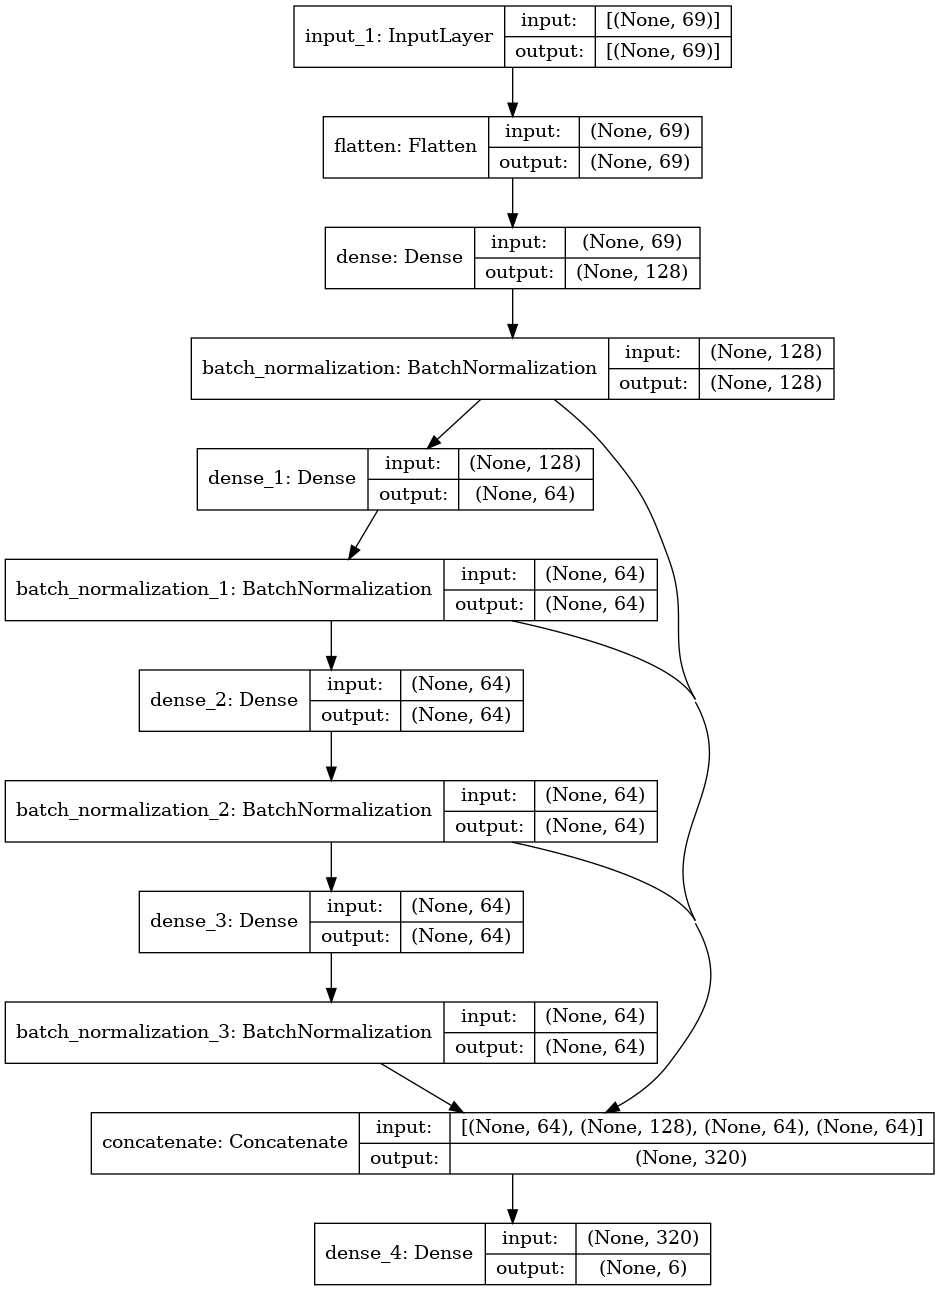

In [17]:
plot_model(
    model, 
    to_file='baseline.png', 
    show_shapes=True,
    show_layer_names=True
)

In [18]:
try:
    # detect and init the TPU
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()
    # instantiate a distribution strategy
    tf_strategy = tf.distribute.experimental.TPUStrategy(tpu)
    print("Running on TPU:", tpu.master())
except:
    tf_strategy = tf.distribute.get_strategy()
    print(f"Running on {tf_strategy.num_replicas_in_sync} replicas")
    print("Number of GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Running on 1 replicas
Number of GPUs Available:  1


In [19]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

### define callbacks
early_stopping = EarlyStopping(
    monitor='val_acc', 
    min_delta=0, 
    patience=10, 
    verbose=0,
    mode='max', 
    baseline=None, 
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_acc', 
    factor=0.5,
    patience=5,
    mode='max'
)

****************************************
Fold 1 || Training
****************************************


2021-12-17 13:27:24.949384: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1306990824 exceeds 10% of free system memory.
2021-12-17 13:27:26.361295: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1306990824 exceeds 10% of free system memory.


Epoch 1/150
2313/2313 [==============================] - 15s 5ms/step - loss: 0.1876 - acc: 0.9472 - val_loss: 0.1273 - val_acc: 0.9549
Epoch 2/150
2313/2313 [==============================] - 12s 5ms/step - loss: 0.1143 - acc: 0.9587 - val_loss: 0.1173 - val_acc: 0.9550
Epoch 3/150
2313/2313 [==============================] - 12s 5ms/step - loss: 0.1031 - acc: 0.9606 - val_loss: 0.1088 - val_acc: 0.9562
Epoch 4/150
2313/2313 [==============================] - 13s 5ms/step - loss: 0.0966 - acc: 0.9620 - val_loss: 0.0998 - val_acc: 0.9588
Epoch 5/150
2313/2313 [==============================] - 12s 5ms/step - loss: 0.0927 - acc: 0.9629 - val_loss: 0.1018 - val_acc: 0.9577
Epoch 6/150
2313/2313 [==============================] - 13s 6ms/step - loss: 0.0901 - acc: 0.9635 - val_loss: 0.0966 - val_acc: 0.9594
Epoch 7/150
2313/2313 [==============================] - 12s 5ms/step - loss: 0.0881 - acc: 0.9640 - val_loss: 0.0960 - val_acc: 0.9592
Epoch 8/150
2313/2313 [=========================

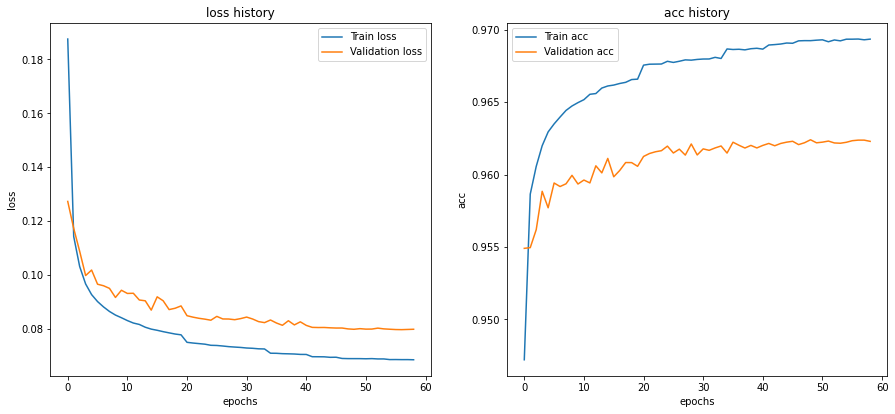

Best training accuracy: 0.96937
Best validation accuracy: 0.96241
****************************************
Fold 2 || Training
****************************************


2021-12-17 13:40:00.098142: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1306990824 exceeds 10% of free system memory.
2021-12-17 13:40:01.412432: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1306990824 exceeds 10% of free system memory.


Epoch 1/150
2313/2313 [==============================] - 13s 5ms/step - loss: 0.1931 - acc: 0.9462 - val_loss: 0.1285 - val_acc: 0.9542
Epoch 2/150
2313/2313 [==============================] - 12s 5ms/step - loss: 0.1144 - acc: 0.9586 - val_loss: 0.1142 - val_acc: 0.9556
Epoch 3/150
2313/2313 [==============================] - 14s 6ms/step - loss: 0.1026 - acc: 0.9607 - val_loss: 0.1068 - val_acc: 0.9570
Epoch 4/150
2313/2313 [==============================] - 12s 5ms/step - loss: 0.0965 - acc: 0.9619 - val_loss: 0.1052 - val_acc: 0.9570
Epoch 5/150
2313/2313 [==============================] - 12s 5ms/step - loss: 0.0926 - acc: 0.9628 - val_loss: 0.1071 - val_acc: 0.9562
Epoch 6/150
2313/2313 [==============================] - 12s 5ms/step - loss: 0.0898 - acc: 0.9635 - val_loss: 0.1005 - val_acc: 0.9579
Epoch 7/150
2313/2313 [==============================] - 12s 5ms/step - loss: 0.0877 - acc: 0.9640 - val_loss: 0.0956 - val_acc: 0.9594
Epoch 8/150
2313/2313 [=========================

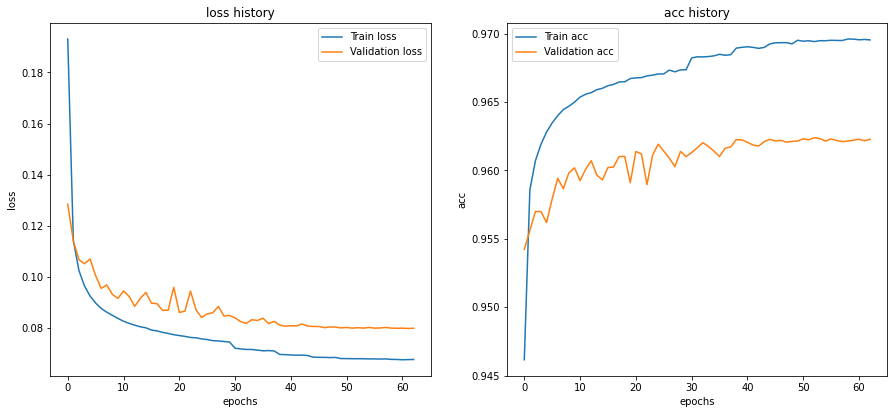

Best training accuracy: 0.96961
Best validation accuracy: 0.96239
****************************************
Fold 3 || Training
****************************************


2021-12-17 13:53:45.274485: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1306990824 exceeds 10% of free system memory.


Epoch 1/150
2313/2313 [==============================] - 13s 5ms/step - loss: 0.1920 - acc: 0.9461 - val_loss: 0.1298 - val_acc: 0.9540
Epoch 2/150
2313/2313 [==============================] - 12s 5ms/step - loss: 0.1146 - acc: 0.9586 - val_loss: 0.1165 - val_acc: 0.9552
Epoch 3/150
2313/2313 [==============================] - 12s 5ms/step - loss: 0.1026 - acc: 0.9607 - val_loss: 0.1065 - val_acc: 0.9572
Epoch 4/150
2313/2313 [==============================] - 12s 5ms/step - loss: 0.0961 - acc: 0.9622 - val_loss: 0.1063 - val_acc: 0.9569
Epoch 5/150
2313/2313 [==============================] - 12s 5ms/step - loss: 0.0925 - acc: 0.9629 - val_loss: 0.0967 - val_acc: 0.9595
Epoch 6/150
2313/2313 [==============================] - 16s 7ms/step - loss: 0.0899 - acc: 0.9635 - val_loss: 0.0958 - val_acc: 0.9595
Epoch 7/150
2313/2313 [==============================] - 12s 5ms/step - loss: 0.0878 - acc: 0.9639 - val_loss: 0.0987 - val_acc: 0.9583
Epoch 8/150
2313/2313 [=========================

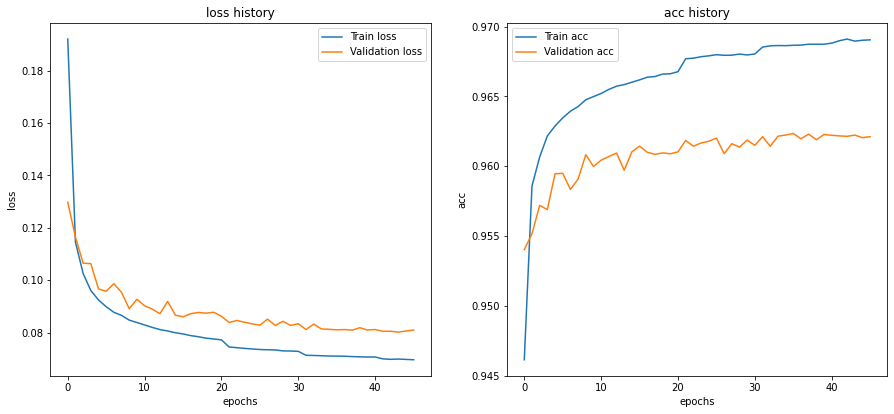

Best training accuracy: 0.96911
Best validation accuracy: 0.96234
****************************************
Fold 4 || Training
****************************************
Epoch 1/150
2313/2313 [==============================] - 13s 5ms/step - loss: 0.1916 - acc: 0.9462 - val_loss: 0.1296 - val_acc: 0.9544
Epoch 2/150
2313/2313 [==============================] - 12s 5ms/step - loss: 0.1145 - acc: 0.9586 - val_loss: 0.1129 - val_acc: 0.9564
Epoch 3/150
2313/2313 [==============================] - 14s 6ms/step - loss: 0.1027 - acc: 0.9607 - val_loss: 0.1053 - val_acc: 0.9580
Epoch 4/150
2313/2313 [==============================] - 16s 7ms/step - loss: 0.0963 - acc: 0.9621 - val_loss: 0.1095 - val_acc: 0.9563
Epoch 5/150
2313/2313 [==============================] - 12s 5ms/step - loss: 0.0929 - acc: 0.9627 - val_loss: 0.1002 - val_acc: 0.9585
Epoch 6/150
2313/2313 [==============================] - 12s 5ms/step - loss: 0.0900 - acc: 0.9635 - val_loss: 0.0938 - val_acc: 0.9605
Epoch 7/150
2313/

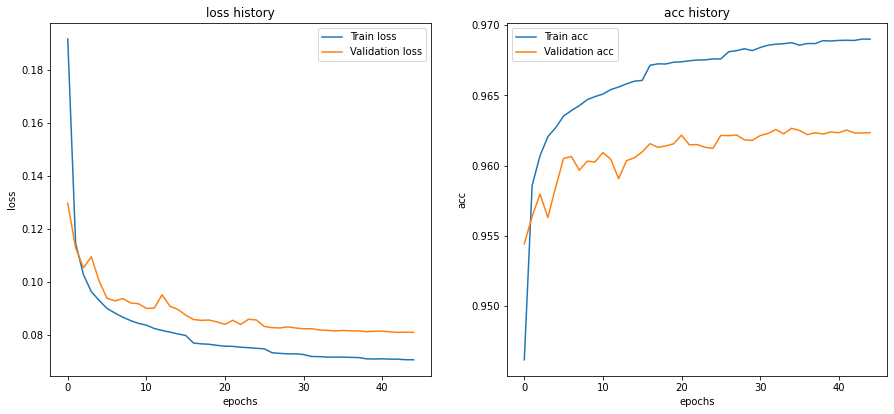

Best training accuracy: 0.96902
Best validation accuracy: 0.96266
****************************************
Fold 5 || Training
****************************************
Epoch 1/150
2313/2313 [==============================] - 13s 5ms/step - loss: 0.1900 - acc: 0.9468 - val_loss: 0.1283 - val_acc: 0.9549
Epoch 2/150
2313/2313 [==============================] - 12s 5ms/step - loss: 0.1138 - acc: 0.9588 - val_loss: 0.1167 - val_acc: 0.9555
Epoch 3/150
2313/2313 [==============================] - 16s 7ms/step - loss: 0.1031 - acc: 0.9606 - val_loss: 0.1044 - val_acc: 0.9581
Epoch 4/150
2313/2313 [==============================] - 15s 7ms/step - loss: 0.0963 - acc: 0.9621 - val_loss: 0.1035 - val_acc: 0.9581
Epoch 5/150
2313/2313 [==============================] - 11s 5ms/step - loss: 0.0927 - acc: 0.9629 - val_loss: 0.0988 - val_acc: 0.9596
Epoch 6/150
2313/2313 [==============================] - 11s 5ms/step - loss: 0.0899 - acc: 0.9636 - val_loss: 0.0963 - val_acc: 0.9595
Epoch 7/150
2313/

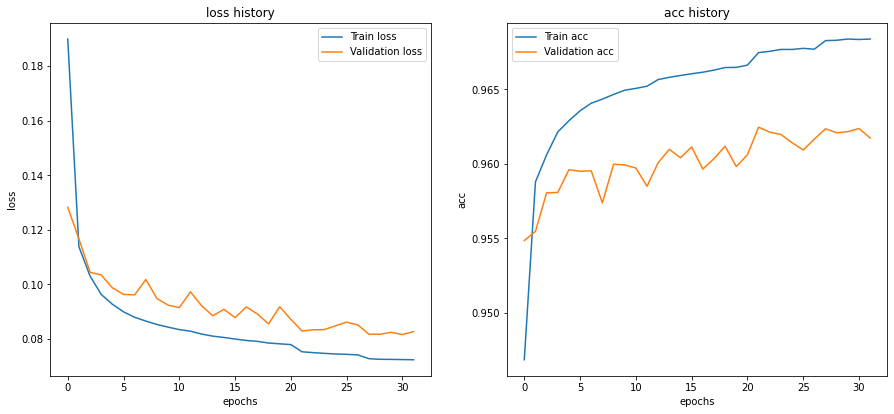

Best training accuracy: 0.96839
Best validation accuracy: 0.96247
****************************************
Fold 6 || Training
****************************************
Epoch 1/150
2313/2313 [==============================] - 13s 5ms/step - loss: 0.1964 - acc: 0.9453 - val_loss: 0.1391 - val_acc: 0.9501
Epoch 2/150
2313/2313 [==============================] - 12s 5ms/step - loss: 0.1144 - acc: 0.9588 - val_loss: 0.1191 - val_acc: 0.9548
Epoch 3/150
2313/2313 [==============================] - 16s 7ms/step - loss: 0.1027 - acc: 0.9608 - val_loss: 0.1041 - val_acc: 0.9582
Epoch 4/150
2313/2313 [==============================] - 16s 7ms/step - loss: 0.0964 - acc: 0.9621 - val_loss: 0.1008 - val_acc: 0.9583
Epoch 5/150
2313/2313 [==============================] - 13s 6ms/step - loss: 0.0924 - acc: 0.9630 - val_loss: 0.0994 - val_acc: 0.9585
Epoch 6/150
2313/2313 [==============================] - 12s 5ms/step - loss: 0.0900 - acc: 0.9635 - val_loss: 0.0949 - val_acc: 0.9595
Epoch 7/150
2313/

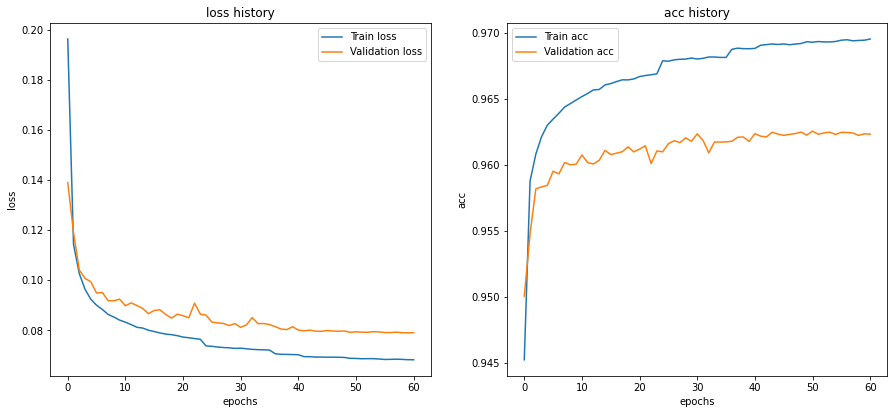

Best training accuracy: 0.96953
Best validation accuracy: 0.96256
****************************************
Fold 7 || Training
****************************************
Epoch 1/150
2313/2313 [==============================] - 14s 6ms/step - loss: 0.1900 - acc: 0.9468 - val_loss: 0.1277 - val_acc: 0.9546
Epoch 2/150
2313/2313 [==============================] - 12s 5ms/step - loss: 0.1140 - acc: 0.9588 - val_loss: 0.1112 - val_acc: 0.9572
Epoch 3/150
2313/2313 [==============================] - 15s 7ms/step - loss: 0.1030 - acc: 0.9607 - val_loss: 0.1066 - val_acc: 0.9570
Epoch 4/150
2313/2313 [==============================] - 16s 7ms/step - loss: 0.0967 - acc: 0.9619 - val_loss: 0.1069 - val_acc: 0.9569
Epoch 5/150
2313/2313 [==============================] - 16s 7ms/step - loss: 0.0931 - acc: 0.9628 - val_loss: 0.1011 - val_acc: 0.9587
Epoch 6/150
2313/2313 [==============================] - 12s 5ms/step - loss: 0.0901 - acc: 0.9635 - val_loss: 0.0985 - val_acc: 0.9589
Epoch 7/150
2313/

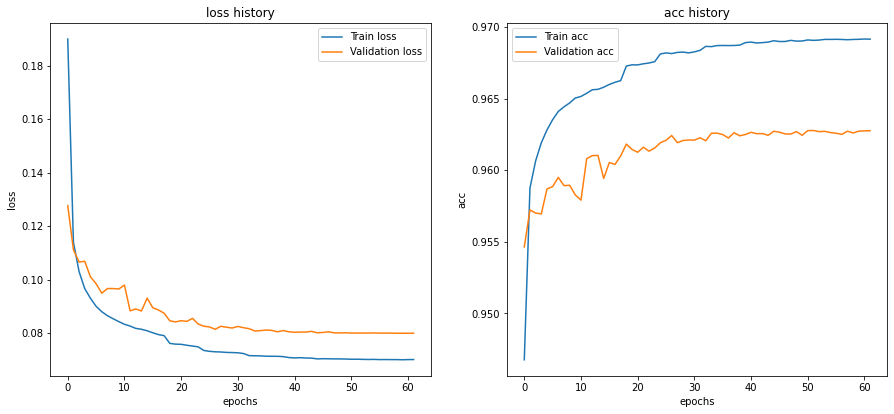

Best training accuracy: 0.96917
Best validation accuracy: 0.96278
****************************************
Fold 8 || Training
****************************************
Epoch 1/150
2313/2313 [==============================] - 13s 5ms/step - loss: 0.1883 - acc: 0.9470 - val_loss: 0.1302 - val_acc: 0.9529
Epoch 2/150
2313/2313 [==============================] - 11s 5ms/step - loss: 0.1134 - acc: 0.9589 - val_loss: 0.1231 - val_acc: 0.9532
Epoch 3/150
2313/2313 [==============================] - 12s 5ms/step - loss: 0.1022 - acc: 0.9609 - val_loss: 0.1106 - val_acc: 0.9556
Epoch 4/150
2313/2313 [==============================] - 11s 5ms/step - loss: 0.0967 - acc: 0.9619 - val_loss: 0.1021 - val_acc: 0.9576
Epoch 5/150
2313/2313 [==============================] - 11s 5ms/step - loss: 0.0929 - acc: 0.9628 - val_loss: 0.1083 - val_acc: 0.9562
Epoch 6/150
2313/2313 [==============================] - 12s 5ms/step - loss: 0.0902 - acc: 0.9635 - val_loss: 0.0970 - val_acc: 0.9586
Epoch 7/150
2313/

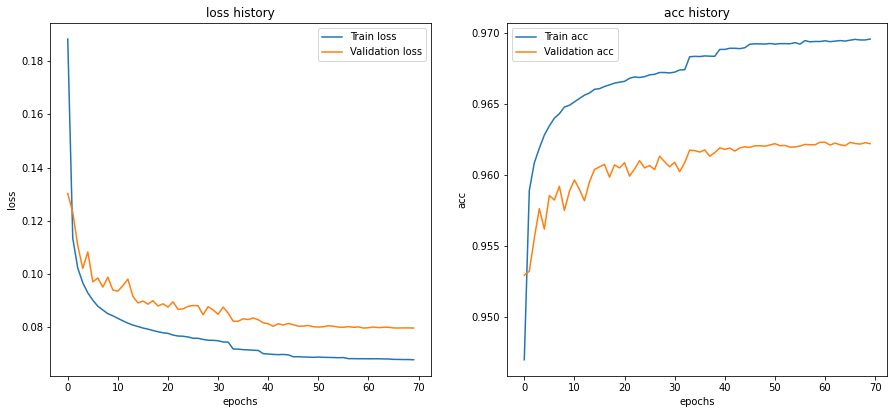

Best training accuracy: 0.96957
Best validation accuracy: 0.96231
****************************************
Fold 9 || Training
****************************************
Epoch 1/150
2313/2313 [==============================] - 14s 6ms/step - loss: 0.1890 - acc: 0.9467 - val_loss: 0.1321 - val_acc: 0.9536
Epoch 2/150
2313/2313 [==============================] - 15s 6ms/step - loss: 0.1146 - acc: 0.9586 - val_loss: 0.1196 - val_acc: 0.9546
Epoch 3/150
2313/2313 [==============================] - 17s 7ms/step - loss: 0.1026 - acc: 0.9608 - val_loss: 0.1057 - val_acc: 0.9577
Epoch 4/150
2313/2313 [==============================] - 17s 7ms/step - loss: 0.0963 - acc: 0.9621 - val_loss: 0.1028 - val_acc: 0.9579
Epoch 5/150
2313/2313 [==============================] - 17s 7ms/step - loss: 0.0924 - acc: 0.9630 - val_loss: 0.1011 - val_acc: 0.9583
Epoch 6/150
2313/2313 [==============================] - 12s 5ms/step - loss: 0.0898 - acc: 0.9635 - val_loss: 0.0935 - val_acc: 0.9600
Epoch 7/150
2313/

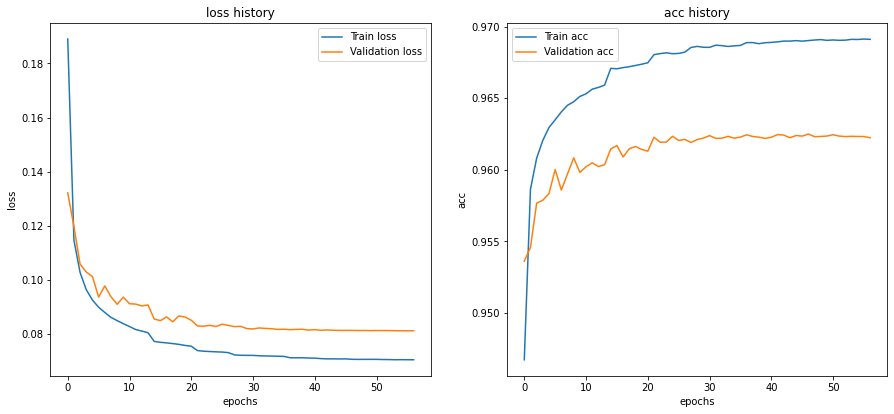

Best training accuracy: 0.96914
Best validation accuracy: 0.96250
****************************************
Fold 10 || Training
****************************************
Epoch 1/150
2313/2313 [==============================] - 13s 5ms/step - loss: 0.1926 - acc: 0.9460 - val_loss: 0.1426 - val_acc: 0.9489
Epoch 2/150
2313/2313 [==============================] - 12s 5ms/step - loss: 0.1142 - acc: 0.9586 - val_loss: 0.1119 - val_acc: 0.9570
Epoch 3/150
2313/2313 [==============================] - 12s 5ms/step - loss: 0.1026 - acc: 0.9606 - val_loss: 0.1058 - val_acc: 0.9580
Epoch 4/150
2313/2313 [==============================] - 12s 5ms/step - loss: 0.0966 - acc: 0.9620 - val_loss: 0.1020 - val_acc: 0.9586
Epoch 5/150
2313/2313 [==============================] - 12s 5ms/step - loss: 0.0926 - acc: 0.9629 - val_loss: 0.1002 - val_acc: 0.9586
Epoch 6/150
2313/2313 [==============================] - 12s 5ms/step - loss: 0.0900 - acc: 0.9635 - val_loss: 0.0987 - val_acc: 0.9588
Epoch 7/150
2313

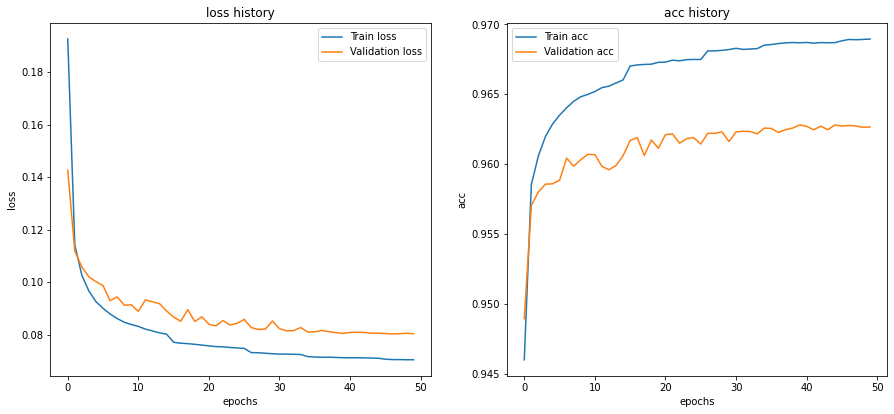

Best training accuracy: 0.96895
Best validation accuracy: 0.96281
****************************************
Fold 11 || Training
****************************************
Epoch 1/150
2313/2313 [==============================] - 13s 5ms/step - loss: 0.1924 - acc: 0.9459 - val_loss: 0.1324 - val_acc: 0.9528
Epoch 2/150
2313/2313 [==============================] - 12s 5ms/step - loss: 0.1155 - acc: 0.9582 - val_loss: 0.1146 - val_acc: 0.9557
Epoch 3/150
2313/2313 [==============================] - 12s 5ms/step - loss: 0.1031 - acc: 0.9606 - val_loss: 0.1106 - val_acc: 0.9558
Epoch 4/150
2313/2313 [==============================] - 12s 5ms/step - loss: 0.0967 - acc: 0.9619 - val_loss: 0.1103 - val_acc: 0.9551
Epoch 5/150
2313/2313 [==============================] - 12s 5ms/step - loss: 0.0928 - acc: 0.9627 - val_loss: 0.1009 - val_acc: 0.9591
Epoch 6/150
2313/2313 [==============================] - 12s 5ms/step - loss: 0.0901 - acc: 0.9634 - val_loss: 0.0950 - val_acc: 0.9602
Epoch 7/150
2313

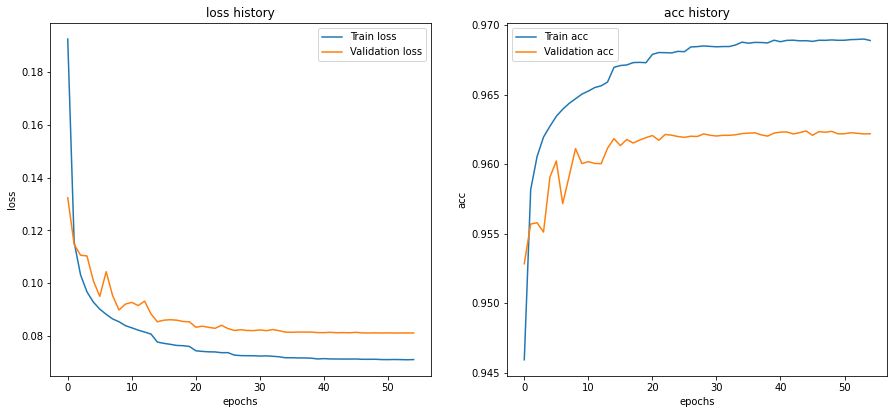

Best training accuracy: 0.96899
Best validation accuracy: 0.96238
****************************************
Fold 12 || Training
****************************************
Epoch 1/150
2313/2313 [==============================] - 14s 6ms/step - loss: 0.1906 - acc: 0.9463 - val_loss: 0.1257 - val_acc: 0.9553
Epoch 2/150
2313/2313 [==============================] - 12s 5ms/step - loss: 0.1150 - acc: 0.9584 - val_loss: 0.1104 - val_acc: 0.9574
Epoch 3/150
2313/2313 [==============================] - 16s 7ms/step - loss: 0.1033 - acc: 0.9605 - val_loss: 0.1059 - val_acc: 0.9575
Epoch 4/150
2313/2313 [==============================] - 17s 7ms/step - loss: 0.0963 - acc: 0.9620 - val_loss: 0.0993 - val_acc: 0.9588
Epoch 5/150
2313/2313 [==============================] - 17s 7ms/step - loss: 0.0933 - acc: 0.9625 - val_loss: 0.0994 - val_acc: 0.9580
Epoch 6/150
2313/2313 [==============================] - 17s 7ms/step - loss: 0.0903 - acc: 0.9633 - val_loss: 0.0998 - val_acc: 0.9578
Epoch 7/150
2313

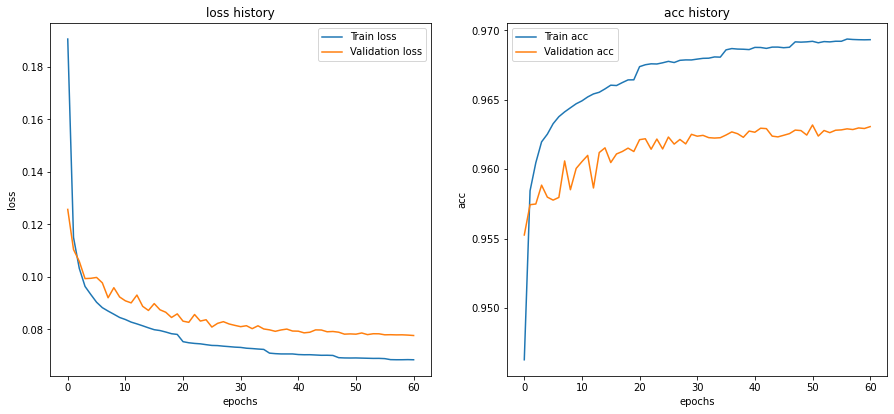

Best training accuracy: 0.96938
Best validation accuracy: 0.96318
****************************************
Fold 13 || Training
****************************************
Epoch 1/150
2313/2313 [==============================] - 14s 5ms/step - loss: 0.1895 - acc: 0.9465 - val_loss: 0.1268 - val_acc: 0.9547
Epoch 2/150
2313/2313 [==============================] - 12s 5ms/step - loss: 0.1143 - acc: 0.9585 - val_loss: 0.1137 - val_acc: 0.9560
Epoch 3/150
2313/2313 [==============================] - 12s 5ms/step - loss: 0.1027 - acc: 0.9606 - val_loss: 0.1039 - val_acc: 0.9580
Epoch 4/150
2313/2313 [==============================] - 12s 5ms/step - loss: 0.0963 - acc: 0.9621 - val_loss: 0.1035 - val_acc: 0.9583
Epoch 5/150
2313/2313 [==============================] - 12s 5ms/step - loss: 0.0925 - acc: 0.9629 - val_loss: 0.1085 - val_acc: 0.9562
Epoch 6/150
2313/2313 [==============================] - 12s 5ms/step - loss: 0.0899 - acc: 0.9634 - val_loss: 0.0984 - val_acc: 0.9584
Epoch 7/150
2313

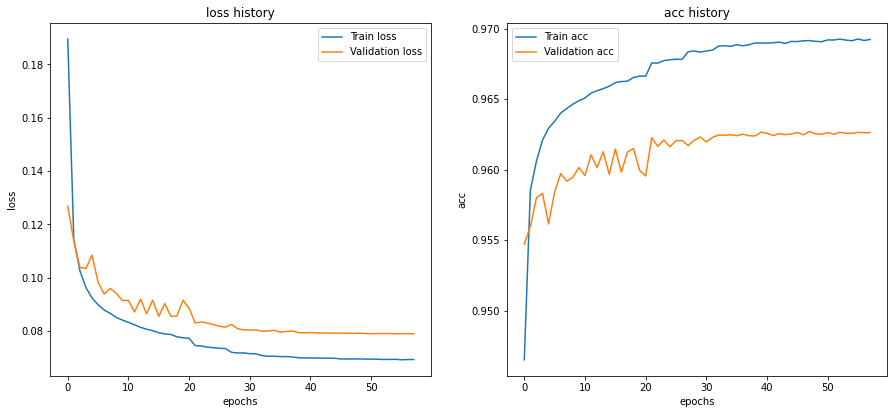

Best training accuracy: 0.96927
Best validation accuracy: 0.96271
****************************************
Fold 14 || Training
****************************************
Epoch 1/150
2313/2313 [==============================] - 13s 5ms/step - loss: 0.1919 - acc: 0.9463 - val_loss: 0.1283 - val_acc: 0.9542
Epoch 2/150
2313/2313 [==============================] - 12s 5ms/step - loss: 0.1138 - acc: 0.9588 - val_loss: 0.1185 - val_acc: 0.9534
Epoch 3/150
2313/2313 [==============================] - 12s 5ms/step - loss: 0.1021 - acc: 0.9610 - val_loss: 0.1066 - val_acc: 0.9571
Epoch 4/150
2313/2313 [==============================] - 12s 5ms/step - loss: 0.0960 - acc: 0.9623 - val_loss: 0.0982 - val_acc: 0.9588
Epoch 5/150
2313/2313 [==============================] - 12s 5ms/step - loss: 0.0923 - acc: 0.9631 - val_loss: 0.0997 - val_acc: 0.9578
Epoch 6/150
2313/2313 [==============================] - 11s 5ms/step - loss: 0.0898 - acc: 0.9637 - val_loss: 0.0977 - val_acc: 0.9588
Epoch 7/150
2313

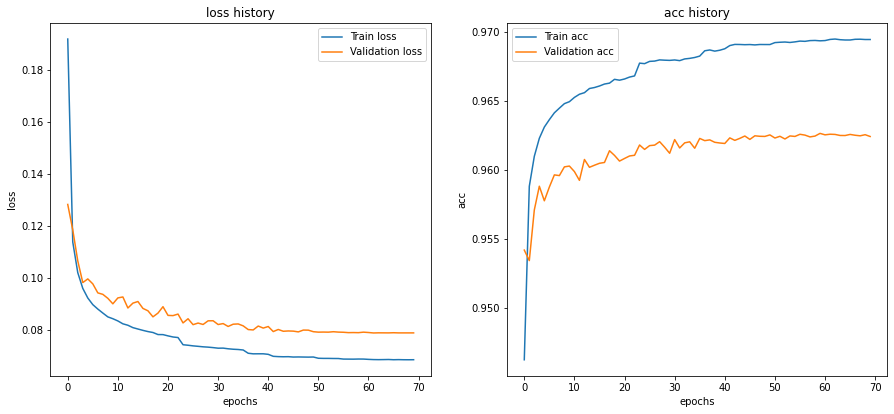

Best training accuracy: 0.96950
Best validation accuracy: 0.96266
****************************************
Fold 15 || Training
****************************************
Epoch 1/150
2313/2313 [==============================] - 13s 5ms/step - loss: 0.1923 - acc: 0.9462 - val_loss: 0.1389 - val_acc: 0.9508
Epoch 2/150
2313/2313 [==============================] - 12s 5ms/step - loss: 0.1139 - acc: 0.9587 - val_loss: 0.1099 - val_acc: 0.9577
Epoch 3/150
2313/2313 [==============================] - 12s 5ms/step - loss: 0.1019 - acc: 0.9611 - val_loss: 0.1043 - val_acc: 0.9589
Epoch 4/150
2313/2313 [==============================] - 12s 5ms/step - loss: 0.0959 - acc: 0.9623 - val_loss: 0.0996 - val_acc: 0.9592
Epoch 5/150
2313/2313 [==============================] - 12s 5ms/step - loss: 0.0919 - acc: 0.9631 - val_loss: 0.0978 - val_acc: 0.9595
Epoch 6/150
2313/2313 [==============================] - 12s 5ms/step - loss: 0.0894 - acc: 0.9638 - val_loss: 0.1036 - val_acc: 0.9572
Epoch 7/150
2313

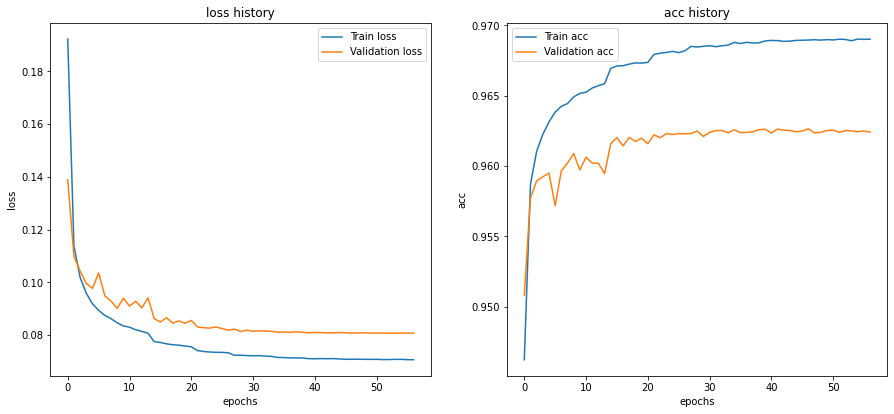

Best training accuracy: 0.96903
Best validation accuracy: 0.96265
****************************************
Fold 16 || Training
****************************************
Epoch 1/150
2313/2313 [==============================] - 13s 5ms/step - loss: 0.1881 - acc: 0.9470 - val_loss: 0.1282 - val_acc: 0.9539
Epoch 2/150
2313/2313 [==============================] - 12s 5ms/step - loss: 0.1141 - acc: 0.9587 - val_loss: 0.1184 - val_acc: 0.9545
Epoch 3/150
2313/2313 [==============================] - 12s 5ms/step - loss: 0.1024 - acc: 0.9608 - val_loss: 0.1081 - val_acc: 0.9560
Epoch 4/150
2313/2313 [==============================] - 12s 5ms/step - loss: 0.0959 - acc: 0.9622 - val_loss: 0.1008 - val_acc: 0.9580
Epoch 5/150
2313/2313 [==============================] - 12s 5ms/step - loss: 0.0924 - acc: 0.9629 - val_loss: 0.0978 - val_acc: 0.9589
Epoch 6/150
2313/2313 [==============================] - 12s 5ms/step - loss: 0.0904 - acc: 0.9635 - val_loss: 0.0943 - val_acc: 0.9597
Epoch 7/150
2313

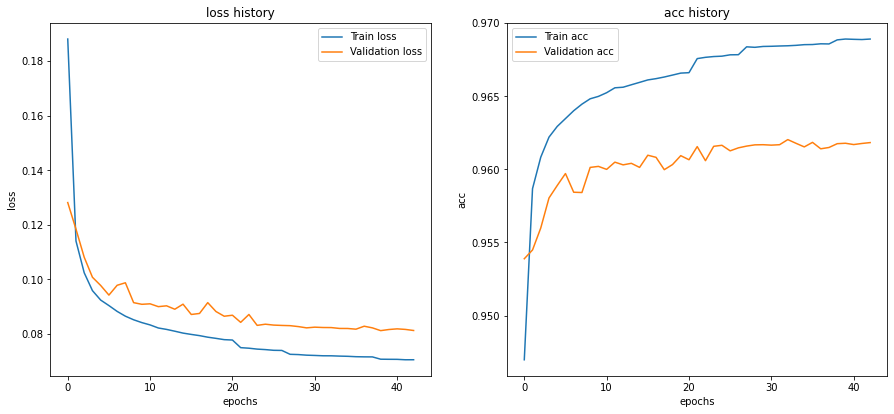

Best training accuracy: 0.96892
Best validation accuracy: 0.96204
****************************************
Fold 17 || Training
****************************************
Epoch 1/150
2313/2313 [==============================] - 13s 5ms/step - loss: 0.1933 - acc: 0.9458 - val_loss: 0.1270 - val_acc: 0.9551
Epoch 2/150
2313/2313 [==============================] - 12s 5ms/step - loss: 0.1141 - acc: 0.9588 - val_loss: 0.1126 - val_acc: 0.9568
Epoch 3/150
2313/2313 [==============================] - 12s 5ms/step - loss: 0.1028 - acc: 0.9607 - val_loss: 0.1045 - val_acc: 0.9576
Epoch 4/150
2313/2313 [==============================] - 12s 5ms/step - loss: 0.0966 - acc: 0.9620 - val_loss: 0.1048 - val_acc: 0.9574
Epoch 5/150
2313/2313 [==============================] - 12s 5ms/step - loss: 0.0929 - acc: 0.9627 - val_loss: 0.0984 - val_acc: 0.9587
Epoch 6/150
2313/2313 [==============================] - 13s 5ms/step - loss: 0.0902 - acc: 0.9635 - val_loss: 0.0984 - val_acc: 0.9582
Epoch 7/150
2313

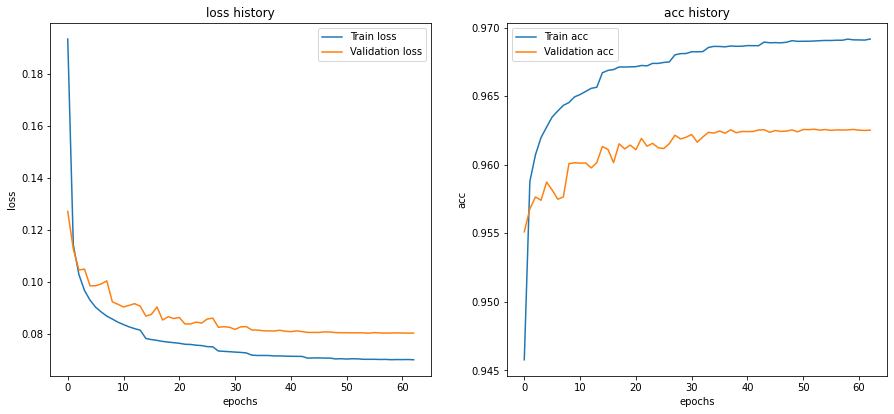

Best training accuracy: 0.96916
Best validation accuracy: 0.96259
****************************************
Fold 18 || Training
****************************************
Epoch 1/150
2313/2313 [==============================] - 13s 5ms/step - loss: 0.1924 - acc: 0.9461 - val_loss: 0.1291 - val_acc: 0.9550
Epoch 2/150
2313/2313 [==============================] - 12s 5ms/step - loss: 0.1133 - acc: 0.9590 - val_loss: 0.1149 - val_acc: 0.9563
Epoch 3/150
2313/2313 [==============================] - 12s 5ms/step - loss: 0.1014 - acc: 0.9612 - val_loss: 0.1051 - val_acc: 0.9583
Epoch 4/150
2313/2313 [==============================] - 12s 5ms/step - loss: 0.0956 - acc: 0.9623 - val_loss: 0.1004 - val_acc: 0.9585
Epoch 5/150
2313/2313 [==============================] - 13s 5ms/step - loss: 0.0922 - acc: 0.9630 - val_loss: 0.1004 - val_acc: 0.9577
Epoch 6/150
2313/2313 [==============================] - 12s 5ms/step - loss: 0.0894 - acc: 0.9637 - val_loss: 0.0938 - val_acc: 0.9603
Epoch 7/150
2313

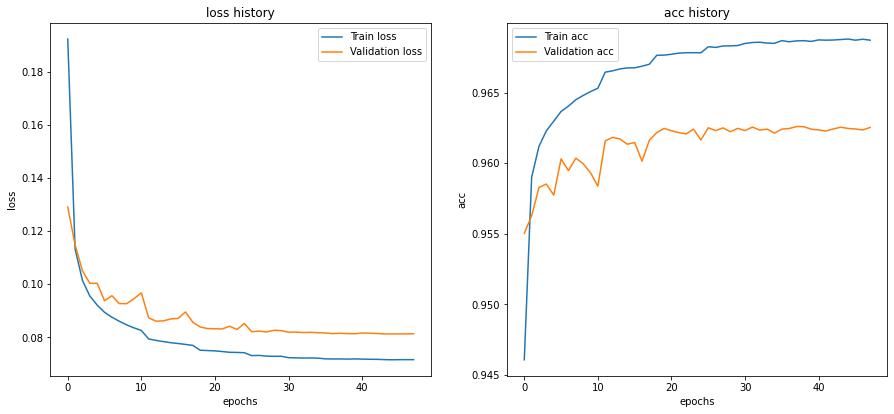

Best training accuracy: 0.96880
Best validation accuracy: 0.96260
****************************************
Fold 19 || Training
****************************************
Epoch 1/150
2313/2313 [==============================] - 13s 5ms/step - loss: 0.1937 - acc: 0.9456 - val_loss: 0.1302 - val_acc: 0.9540
Epoch 2/150
2313/2313 [==============================] - 12s 5ms/step - loss: 0.1140 - acc: 0.9588 - val_loss: 0.1165 - val_acc: 0.9553
Epoch 3/150
2313/2313 [==============================] - 12s 5ms/step - loss: 0.1027 - acc: 0.9608 - val_loss: 0.1110 - val_acc: 0.9558
Epoch 4/150
2313/2313 [==============================] - 12s 5ms/step - loss: 0.0967 - acc: 0.9619 - val_loss: 0.1049 - val_acc: 0.9572
Epoch 5/150
2313/2313 [==============================] - 11s 5ms/step - loss: 0.0926 - acc: 0.9629 - val_loss: 0.0983 - val_acc: 0.9592
Epoch 6/150
2313/2313 [==============================] - 12s 5ms/step - loss: 0.0905 - acc: 0.9633 - val_loss: 0.0970 - val_acc: 0.9592
Epoch 7/150
2313

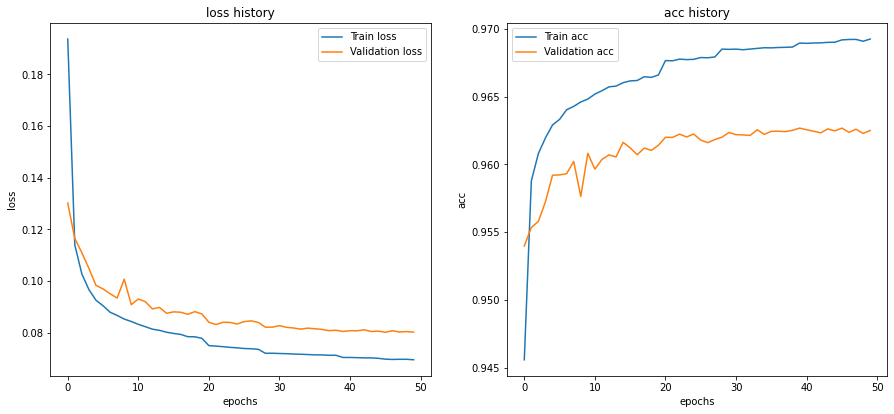

Best training accuracy: 0.96924
Best validation accuracy: 0.96267
****************************************
Fold 20 || Training
****************************************
Epoch 1/150
2313/2313 [==============================] - 13s 5ms/step - loss: 0.1865 - acc: 0.9473 - val_loss: 0.1271 - val_acc: 0.9547
Epoch 2/150
2313/2313 [==============================] - 12s 5ms/step - loss: 0.1130 - acc: 0.9589 - val_loss: 0.1176 - val_acc: 0.9549
Epoch 3/150
2313/2313 [==============================] - 12s 5ms/step - loss: 0.1018 - acc: 0.9609 - val_loss: 0.1058 - val_acc: 0.9578
Epoch 4/150
2313/2313 [==============================] - 11s 5ms/step - loss: 0.0958 - acc: 0.9622 - val_loss: 0.1192 - val_acc: 0.9526
Epoch 5/150
2313/2313 [==============================] - 12s 5ms/step - loss: 0.0921 - acc: 0.9631 - val_loss: 0.0993 - val_acc: 0.9586
Epoch 6/150
2313/2313 [==============================] - 12s 5ms/step - loss: 0.0895 - acc: 0.9637 - val_loss: 0.1023 - val_acc: 0.9573
Epoch 7/150
2313

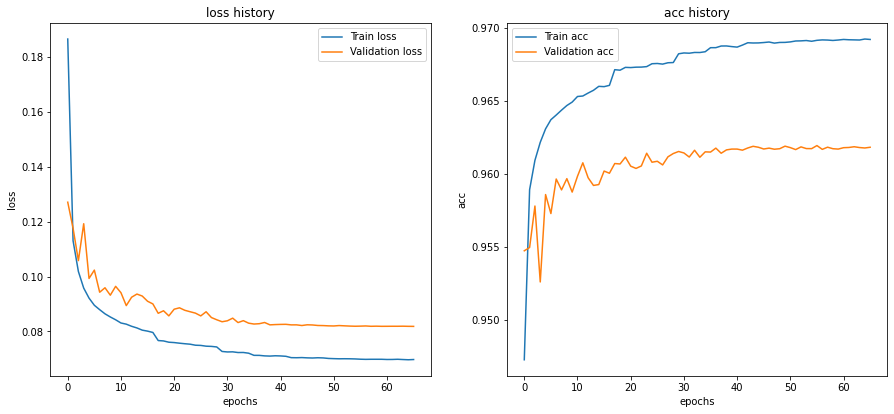

Best training accuracy: 0.96923
Best validation accuracy: 0.96193


In [20]:
N_FOLDS = 20

### cross-validation 
cv = KFold(n_splits=N_FOLDS, shuffle=True, random_state=1)

predictions = np.zeros((len(Xt), len(le.classes_)))
oof = np.zeros((original_len, len(le.classes_)))
scores = list()

with tf_strategy.scope():
    for fold, (idx_train, idx_valid) in enumerate(cv.split(X, y)):
        
        idx_valid = idx_valid[idx_valid<original_len]
        X_train, y_train = X[idx_train, :], target[idx_train]
        X_valid, y_valid = X[idx_valid, :], target[idx_valid]
        
        ss = RobustScaler()
        X_train = ss.fit_transform(X_train)
        X_valid = ss.transform(X_valid)

        model = get_model(**dnn_params)
        
        optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)    
    
        model.compile(
            optimizer='adam',
            loss=tf.keras.losses.SparseCategoricalCrossentropy(), #SparseCategoricalFocalLoss(gamma=2.), tf.keras.losses.SparseCategoricalCrossentropy()
            metrics=['acc']
        )

        print('**'*20)
        print(f"Fold {fold+1} || Training")
        print('**'*20)

        history = model.fit(
            X_train, y_train,
            validation_data=(X_valid, y_valid),
            batch_size=1024*2,
            epochs=150,
            verbose=1,
            shuffle=True,
            callbacks=[
                early_stopping,
                reduce_lr
            ]
        )
        
        plot_keras_history(history, ['loss', 'acc'])
        
        print(f"Best training accuracy: {np.max(history.history['acc']):0.5f}")
        print(f"Best validation accuracy: {np.max(history.history['val_acc']):0.5f}")
        scores.append(np.max(history.history['val_acc']))

        oof[idx_valid] = model.predict(X_valid, batch_size=4096) 

        predictions += model.predict(ss.transform(Xt), batch_size=4096)
        
        del([X_train, y_train, X_valid, y_valid])
        gc.collect()

In [21]:
print(f"Average cv accuracy: {np.mean(scores):0.5f} (std={np.std(scores):0.5f})")

Average cv accuracy: 0.96253 (std=0.00027)


In [22]:
submission.Cover_Type = le.inverse_transform(np.argmax(predictions, axis=1)) + 1
submission.to_csv("submission.csv", index=False)

In [23]:
oof = pd.DataFrame(oof, columns=[f"prob_{i}" for i in le.classes_])
oof.insert(loc=0, column='Id', value=range(len(oof)))
oof.to_csv("oof.csv", index=False)